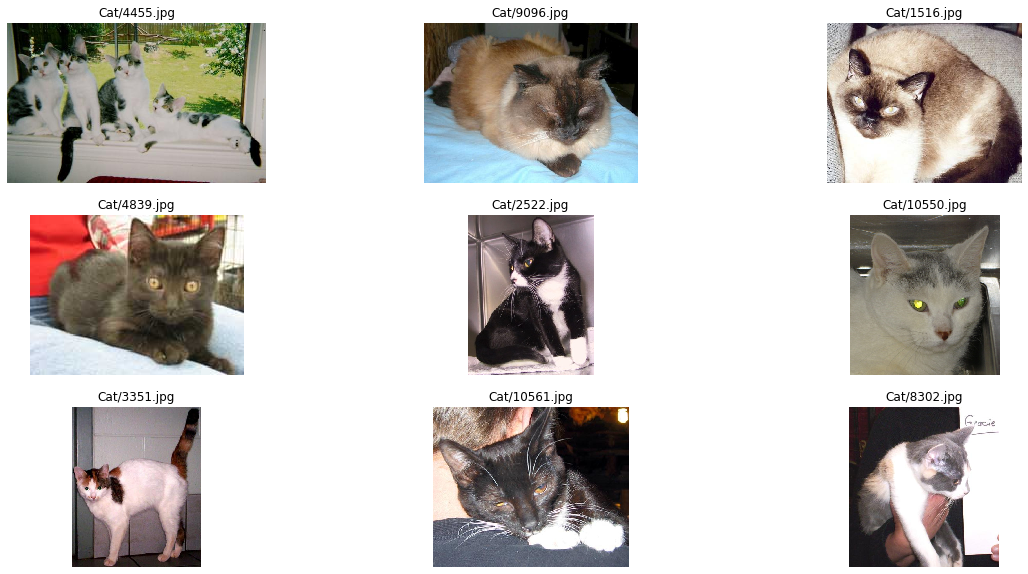

In [2]:
############################ STEP1: EDA  ########################
#The cats and dogs dataset
from matplotlib import pyplot as plt
import os
import random

# Get list of file names
_, _, cat_images = next(os.walk('Dataset\\PetImages\\Cat'))


# Prepare a 3x3 plot (total of 9 images)
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Randomly select and plot an image
for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('Dataset\\PetImages\\Cat\\'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/'+img)
plt.show()

#The images have different dimensions.


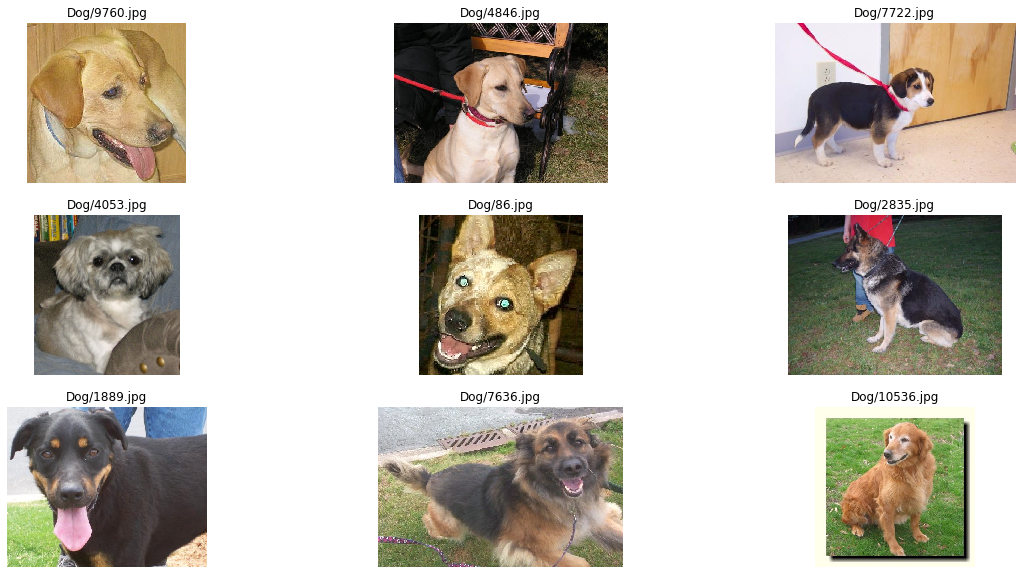

In [3]:
# Get list of file names
_, _, dog_images = next(os.walk('Dataset/PetImages/Dog'))

# Prepare a 3x3 plot (total of 9 images)
fig, ax = plt.subplots(3,3, figsize=(20,10))

# Randomly select and plot an image
for idx, img in enumerate(random.sample(dog_images, 9)):
    img_read = plt.imread('Dataset/PetImages/Dog/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Dog/'+img)
plt.show()

In [4]:
# Managing image data for Keras
from utils import train_test_split

src_folder = 'Dataset/PetImages/'
train_test_split(src_folder)

#Create /Train/Cat, /Train/Dog, /Test/Cat, and /Test/Dog folders.
#Randomly assign 80% of the the images as train images and 20% of the images as test images.
#Copy those images into the respective folders.

Using TensorFlow backend.


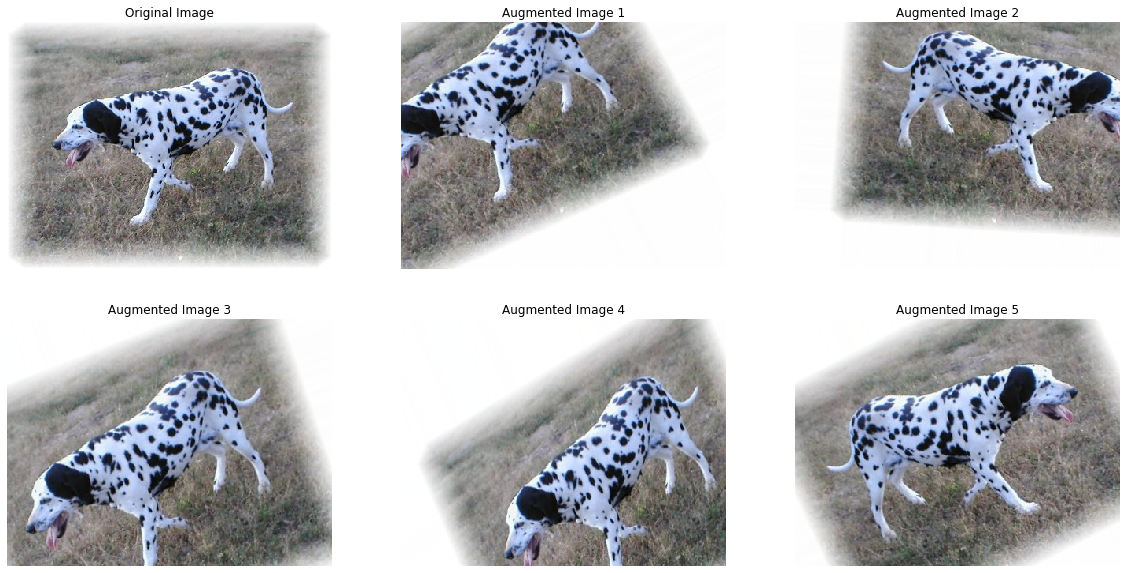

In [5]:
# Image augmentation
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rotation_range = 30,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

fig, ax = plt.subplots(2,3, figsize=(20,10))
all_images = []

_, _, dog_images = next(os.walk('Dataset/PetImages/Train/Dog/'))
random_img = random.sample(dog_images, 1)[0]
random_img = plt.imread('Dataset/PetImages/Train/Dog/'+random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))

for idx, img in enumerate(all_images):
    ax[int(idx/3), idx%3].imshow(img)
    ax[int(idx/3), idx%3].axis('off')
    if idx == 0:
        ax[int(idx/3), idx%3].set_title('Original Image')
    else:
        ax[int(idx/3), idx%3].set_title('Augmented Image {}'.format(idx))

plt.show()

In [ ]:
############################ STEP2: CNN MODEL  ########################

In [31]:
import os
import random
import warnings
warnings.filterwarnings("ignore")
from utils import train_test_split

src = 'Dataset/PetImages/'

# Check if the dataset has been downloaded. If not, direct user to download the dataset first
if not os.path.isdir(src):
    print("""
          Dataset not found in your computer.
          Please follow the instructions in the link below to download the dataset:
          https://raw.githubusercontent.com/PacktPublishing/Neural-Network-Projects-with-Python/master/chapter4/how_to_download_the_dataset.txt
          """)
    quit()

# create the train/test folders if it does not exists already
if not os.path.isdir(src+'train/'):
    train_test_split(src)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

# Define hyperparameters
# Convolutional layer filter size: Most modern CNNs use a small filter size of 3 x 3.
# Number of filters: Let's use a filter number of 32. This is a good balance between speed and performance.
# Input size: As we've seen in an earlier section, the input images have different sizes, with their width and height approximately 150 px. Let's use an input size of 32 x 32 pixels. This compresses the original image, which can result in some information loss, but helps to speed up the training of our neural network.
# Max pooling size: A common max pooling size is 2 x 2. This will halve the input layer dimensions.
# Batch size: This corresponds to the number of training samples to use in each mini batch during gradient descent. A large batch size results in more accurate training but longer training time and memory usage. Let's use a batch size of 16.
# Steps per epoch: This is the number of iterations in each training epoch. Typically, this is equal to the number of training samples divided by the batch size.
# Epochs: The number of epochs to train our data. Note that, in neural networks, the number of epochs refers to the number of times the model sees each training sample during training. Multiple epochs are usually needed, as gradient descent is an iterative optimization method. Let's train our model for 10 epochs. This means that each training sample will be passed to the the model 10 times during training.

FILTER_SIZE = 3
NUM_FILTERS = 32
INPUT_SIZE  = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 16
STEPS_PER_EPOCH = 20000//BATCH_SIZE
EPOCHS = 10

model = Sequential()
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), input_shape = (INPUT_SIZE, INPUT_SIZE, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE)))
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale = 1./255)

training_set = training_data_generator.flow_from_directory(src+'Train/',
                                                target_size = (INPUT_SIZE, INPUT_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary')

test_set = testing_data_generator.flow_from_directory(src+'Test/',
                                             target_size = (INPUT_SIZE, INPUT_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'binary')

model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose=1)

score = model.evaluate_generator(test_set, steps=100)

for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))

W1013 12:25:31.438986 10288 deprecation_wrapper.py:119] From C:\Users\M1040943\AppData\Local\conda\conda\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1013 12:25:31.452950 10288 deprecation.py:506] From C:\Users\M1040943\AppData\Local\conda\conda\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1013 12:25:31.518784 10288 deprecation_wrapper.py:119] From C:\Users\M1040943\AppData\Local\conda\conda\envs\tensorflow_cpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1013 12:25:31.555674 10288 de

Found 19997 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10
1250/1250 [==============================] - 69s 56ms/step - loss: 0.6390 - acc: 0.6267 3s - loss: 0.6416 - a
Epoch 2/10
1250/1250 [==============================] - 49s 40ms/step - loss: 0.5468 - acc: 0.7244
Epoch 3/10
1250/1250 [==============================] - 50s 40ms/step - loss: 0.5068 - acc: 0.7543
Epoch 4/10
1250/1250 [==============================] - 52s 42ms/step - loss: 0.4763 - acc: 0.7752
Epoch 5/10
1250/1250 [==============================] - 51s 41ms/step - loss: 0.4548 - acc: 0.7883
Epoch 6/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.4270 - acc: 0.8003
Epoch 7/10
1250/1250 [==============================] - 52s 41ms/step - loss: 0.4063 - acc: 0.8125
Epoch 8/10
1250/1250 [==============================] - 52s 42ms/step - loss: 0.3849 - acc: 0.8233
Epoch 9/10
1250/1250 [==============================] - 52s 42ms/step - loss: 0.3582 - acc: 0.8379
Ep

In [20]:
############################ STEP3: VGG16 MODEL  ########################

In [32]:
import os
import random
import warnings
warnings.filterwarnings("ignore")
from utils import train_test_split

src = 'Dataset/PetImages/'

# Check if the dataset has been downloaded. If not, direct user to download the dataset first
if not os.path.isdir(src):
    print("""
          Dataset not found in your computer.
          Please follow the instructions in the link below to download the dataset:
          https://raw.githubusercontent.com/PacktPublishing/Neural-Network-Projects-with-Python/master/chapter4/how_to_download_the_dataset.txt
          """)
    quit()


# create the train/test folders if it does not exists already
if not os.path.isdir(src+'train/'):
	train_test_split(src)

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator

# Define hyperparameters
INPUT_SIZE = 128 #Change this to 48 if the code is taking too long to run
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(INPUT_SIZE,INPUT_SIZE,3))

# Freeze the pre-trained layers
for layer in vgg16.layers:
    layer.trainable = False

# Add a fully connected layer with 1 node at the end 
input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(input=input_, output=last_layer)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale = 1./255)

training_set = training_data_generator.flow_from_directory(src+'Train/',
                                                target_size = (INPUT_SIZE, INPUT_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary')

test_set = testing_data_generator.flow_from_directory(src+'Test/',
                                             target_size = (INPUT_SIZE, INPUT_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'binary')

print("""
      Caution: VGG16 model training can take up to an hour if you are not running Keras on a GPU.
      If the code takes too long to run on your computer, you may reduce the INPUT_SIZE paramater in the code to speed up model training.
      """)

model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose=1)

score = model.evaluate_generator(test_set, steps=100)

for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))



58892288/58889256 [==============================] - 50s 1us/step
Found 19997 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.

      Caution: VGG16 model training can take up to an hour if you are not running Keras on a GPU.
      If the code takes too long to run on your computer, you may reduce the INPUT_SIZE paramater in the code to speed up model training.
      
Epoch 1/3
200/200 [==============================] - 460s 2s/step - loss: 0.3850 - acc: 0.8147
Epoch 2/3
200/200 [==============================] - 460s 2s/step - loss: 0.2852 - acc: 0.8788
Epoch 3/3
200/200 [==============================] - 448s 2s/step - loss: 0.2798 - acc: 0.8728
loss: 0.2591250878572464
acc: 0.893125
